In [ ]:
!pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
API_KEY = "Y3MCPN3KHDU3TYGR"
stocks = ['META', 'AAPL', 'GOOGL', 'TSLA', "AMD", "AMZN", "NVDA", "JPM", "COST", "TSM"]
data_df = pd.DataFrame()
for stock in stocks:
    ts = TimeSeries(key=API_KEY, output_format='pandas')
    data = ts.get_daily(symbol=stock, outputsize='full')[0]
    data_df[stock+"_close"] = data[['4. close']]
data_df = data_df.iloc[::-1]


In [22]:
close_df = data_df.copy()
diff_df = close_df.diff()
diff_df.columns = [stock+'_diff' for stock in stocks]
diff_df = diff_df.shift(-1)
for i in range(1,61):
    diff_df[[f"{stock}_lag_{i}" for stock in stocks]] = diff_df[[stock+'_diff' for stock in stocks]].shift(i)
df = pd.concat([close_df, diff_df], axis = 1)
df = df.dropna()
df = df.iloc[::,::-1]
df

,TSM_lag_60,COST_lag_60,JPM_lag_60,NVDA_lag_60,AMZN_lag_60,AMD_lag_60,TSLA_lag_60,GOOGL_lag_60,AAPL_lag_60,META_lag_60,...,TSM_close,COST_close,JPM_close,NVDA_close,AMZN_close,AMD_close,TSLA_close,GOOGL_close,AAPL_close,META_close
date,,,,,,,,,,,,,,,,,,,,,
2012-08-14,0.14,0.79,-0.98,0.21,4.26,0.29,1.21,13.71,30.90,-4.2018,...,14.40,95.67,37.10,14.59,233.19,4.12,29.42,668.66,631.69,20.380
2012-08-15,-0.02,-0.35,1.50,-0.15,-2.78,-0.14,2.02,-13.31,-4.31,-3.0300,...,14.42,96.47,37.07,14.48,237.42,4.19,29.40,667.54,630.83,21.200
2012-08-16,-0.32,-0.07,0.25,0.30,1.95,-0.08,0.23,8.66,13.59,1.0000,...,14.45,96.48,37.10,14.78,241.55,4.17,30.30,672.87,636.34,19.870
2012-08-17,-0.12,1.17,-0.29,-0.33,-2.04,-0.06,-0.70,-5.80,-5.24,1.0300,...,14.40,96.14,36.98,14.65,241.17,4.10,30.01,677.14,648.11,19.050
2012-08-20,0.02,0.00,-0.47,0.29,-2.35,0.20,-0.51,-12.13,-3.03,-1.1200,...,14.50,96.02,37.37,14.65,240.35,4.09,29.51,675.54,665.15,20.011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-18,-5.10,-17.34,-7.99,-1.48,-10.63,-3.61,-39.73,-7.02,-5.43,-22.2500,...,173.13,898.05,234.97,115.43,192.82,103.51,225.31,160.67,212.69,582.360
2025-03-19,-0.92,-9.94,2.59,1.77,2.77,-2.53,-3.96,0.11,1.74,-1.6200,...,173.76,904.05,239.11,117.52,195.54,106.23,235.86,163.89,215.24,584.060
2025-03-20,2.57,-0.73,4.64,4.02,1.63,0.33,-15.11,2.90,4.70,-10.3200,...,177.47,895.40,239.01,118.53,194.95,107.14,236.26,162.80,214.10,586.000


In [23]:
X = df.iloc[:,0:600].to_numpy()
y = df.iloc[:,600:610].to_numpy()
split_index = int(len(X) * 0.9)
X_train , X_test = X[:split_index] , X[split_index:]
y_train , y_test = y[:split_index] , y[split_index:]
X_train = X_train.reshape(X_train.shape[0], 60, 10)
X_test = X_test.reshape(X_test.shape[0], 60, 10)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [24]:
model1 = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True,input_shape = (60, 10)),
    tf.keras.layers.LSTM(64,input_shape = (60, 128)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
     tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(10)
])
model1.compile(optimizer='adam',loss='mse', metrics=['mae'])
model1.fit(train_ds.batch(32), epochs = 8,validation_data = test_ds.batch(32))
model1.save("model2.keras")
model2 = tf.keras.models.load_model("model2.keras")

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 226.6414 - mae: 3.4797 - val_loss: 446.2113 - val_mae: 5.1864
Epoch 2/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 226.5850 - mae: 3.4891 - val_loss: 446.2855 - val_mae: 5.1815
Epoch 3/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 226.4839 - mae: 3.4990 - val_loss: 446.7602 - val_mae: 5.1948
Epoch 4/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 226.2070 - mae: 3.5079 - val_loss: 447.0503 - val_mae: 5.2008
Epoch 5/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 226.2250 - mae: 3.5201 - val_loss: 447.2274 - val_mae: 5.2170
Epoch 6/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 225.6265 - mae: 3.5667 - val_loss: 446.8715 - val_mae: 5.2208
Epoch 7/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 224.6085 - mae: 3.5670 - val_loss: 446.7126 - val_mae: 5.2160
Epoch 8/8
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 221.4282 - mae: 3.5622 - val_loss: 446.4974 - val_mae: 5.2175


In [25]:
y_pred1 = model1.predict(X_test, batch_size=1)
print(f"Naive MAE {mean_absolute_error(y_test, np.zeros_like(y_test))}")
print(f"Model1 MAE {mean_absolute_error(y_test, y_pred1)}")

317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Naive MAE 5.190305993690852
Model1 MAE 5.217492360947487


In [26]:
backtest1 = pd.DataFrame()

close_col_names = df.iloc[split_index:,610:].columns
diff_true_col_names = df.iloc[split_index:,600:610].columns.map(lambda x : x + '_true')
backtest1[close_col_names] = df.iloc[split_index:,610:]
backtest1[diff_true_col_names] = df.iloc[split_index:,600:610]
signal_true_col_names = diff_true_col_names.map(lambda x : x.replace("_diff", "_signal"))
for i in range(len(signal_true_col_names)):
    backtest1[signal_true_col_names[i]] = backtest1[diff_true_col_names[i]] > 0

diff_pred_col_names = diff_true_col_names.map(lambda x : x.replace("_true", "_pred"))
backtest1[diff_pred_col_names] = y_pred1
signal_pred_col_names = diff_pred_col_names.map(lambda x : x.replace("_diff", "_signal"))
for i in range(len(signal_pred_col_names)):
    backtest1[signal_pred_col_names[i]] = backtest1[diff_pred_col_names[i]] > 0

In [27]:
print(classification_report(backtest1[signal_true_col_names].values.flatten(), backtest1[signal_pred_col_names].values.flatten()))

              precision    recall  f1-score   support

       False       0.46      0.53      0.49      1473
        True       0.53      0.46      0.50      1697

    accuracy                           0.50      3170
   macro avg       0.50      0.50      0.50      3170
weighted avg       0.50      0.50      0.50      3170



In [28]:
initial_cash = 1000
cash = initial_cash
portfolio = {col: 0.0 for col in close_col_names}

for row_index in range(len(backtest1)):

    stock_prices = backtest1.iloc[row_index][close_col_names]
    signals = backtest1.iloc[row_index][signal_pred_col_names]

    investable_cash = cash  # Reset available cash for this round
    num_buy_signals = signals.sum()

    if num_buy_signals > 0:
        weight = 1 / num_buy_signals  # Equal weight for each buy

        for stock, signal in zip(close_col_names, signals):
            price = stock_prices[stock]

            if signal and investable_cash > 0 and price > 0:  # Buy logic
                allocated_cash = weight * investable_cash
                shares_to_buy = allocated_cash / price
                portfolio[stock] += shares_to_buy
                cash -=  shares_to_buy * price  # Prevent negative cash

                # Update investable cash after each buy
                investable_cash = cash

            elif not signal and portfolio[stock] > 0:  # Sell logic
                cash += portfolio[stock] * price  # Sell all holdings
                portfolio[stock] = 0  # Reset holdings



final_prices = backtest1.iloc[-1][close_col_names]
for stock in close_col_names:
    if portfolio[stock] > 0:  # Avoid unnecessary operations
        cash += portfolio[stock] * final_prices[stock]  # Sell remaining stocks
        portfolio[stock] = 0  # Reset portfolio


final_profit = cash - initial_cash
returns = (final_profit / initial_cash) * 100
print(f"Final Cash: ${cash:.2f}")
print(f"Total Profit/Loss: ${final_profit:.2f}")
print(f"Returns: {returns:.2f}%")

Final Cash: $1456.19
Total Profit/Loss: $456.19
Returns: 45.62%


Final Cash: $1456.19
Total Profit/Loss: $456.19
Returns: 45.62%


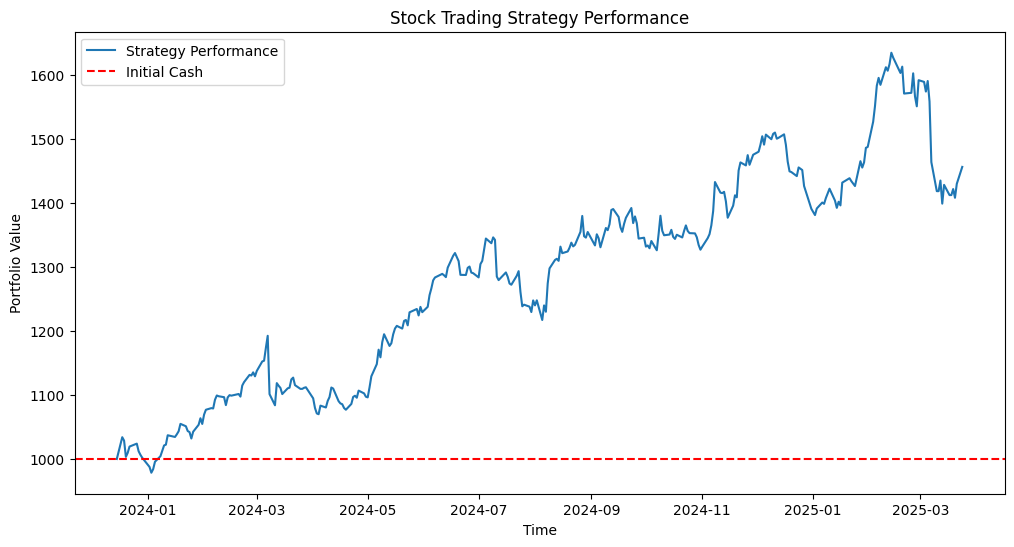

In [29]:
initial_cash = 1000
cash = initial_cash
portfolio = {col: 0.0 for col in close_col_names}
portfolio_values = []

for row_index in range(len(backtest1)):

    stock_prices = backtest1.iloc[row_index][close_col_names]
    signals = backtest1.iloc[row_index][signal_pred_col_names]

    investable_cash = cash  # Reset available cash for this round
    num_buy_signals = signals.sum()

    if num_buy_signals > 0:
        weight = 1 / num_buy_signals  # Equal weight for each buy

        for stock, signal in zip(close_col_names, signals):
            price = stock_prices[stock]

            if signal and investable_cash > 0 and price > 0:  # Buy logic
                allocated_cash = weight * investable_cash
                shares_to_buy = allocated_cash / price
                portfolio[stock] += shares_to_buy
                cash = max(0, cash - shares_to_buy * price)  # Prevent negative cash

                # Update investable cash after each buy
                investable_cash = cash

            elif not signal and portfolio[stock] > 0:  # Sell logic
                cash += portfolio[stock] * price  # Sell all holdings
                portfolio[stock] = 0  # Reset holdings

    # Calculate portfolio value
    stock_value = sum(portfolio[s] * stock_prices[s] for s in close_col_names)
    total_value = cash + stock_value
    portfolio_values.append(total_value)

# **Sell everything at the last available price**
final_prices = backtest1.iloc[-1][close_col_names]
for stock in close_col_names:
    if portfolio[stock] > 0:  # Avoid unnecessary operations
        cash += portfolio[stock] * final_prices[stock]  # Sell remaining stocks
        portfolio[stock] = 0  # Reset portfolio

# **Calculate final profit**
final_profit = cash - initial_cash
returns = (final_profit / initial_cash) * 100

print(f"Final Cash: ${cash:.2f}")
print(f"Total Profit/Loss: ${final_profit:.2f}")
print(f"Returns: {returns:.2f}%")

# **Plot performance**
portfolio_df = pd.DataFrame({"Portfolio Value": portfolio_values}, index=backtest1.index)
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df, label="Strategy Performance")
plt.axhline(initial_cash, color='r', linestyle='--', label="Initial Cash")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.title("Stock Trading Strategy Performance")
plt.show()


Final Cash: $1242.32
Total Profit/Loss: $242.32
Returns: 24.23%


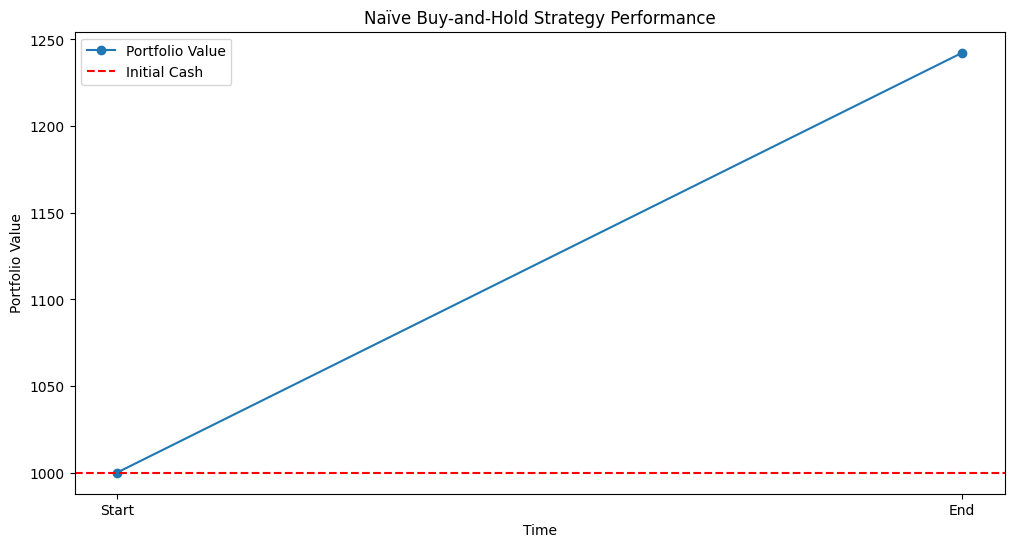

In [30]:
# Initialize capital
initial_cash = 1000
cash = initial_cash

# Get first and last close prices
first_prices = backtest1.iloc[0][close_col_names]
last_prices = backtest1.iloc[-1][close_col_names]

# **1️⃣ Buy all stocks proportionally on the first day**
num_stocks = len(close_col_names)
portfolio = {stock: 0 for stock in close_col_names}

# Equal weight allocation per stock
weight_per_stock = 1 / num_stocks
investable_cash = cash

for stock in close_col_names:
    price = first_prices[stock]
    if price > 0:  # Avoid division errors
        allocated_cash = weight_per_stock * investable_cash
        shares_to_buy = allocated_cash / price
        portfolio[stock] = shares_to_buy
        cash -= shares_to_buy * price  # Deduct cash

# **2️⃣ Hold (No trading in between)**

# **3️⃣ Sell all stocks on the last day**
for stock in close_col_names:
    cash += portfolio[stock] * last_prices[stock]
    portfolio[stock] = 0  # Reset portfolio

# **4️⃣ Calculate final profit & return**
final_profit = cash - initial_cash
returns = (final_profit / initial_cash) * 100

print(f"Final Cash: ${cash:.2f}")
print(f"Total Profit/Loss: ${final_profit:.2f}")
print(f"Returns: {returns:.2f}%")

# **5️⃣ Plot portfolio performance**
portfolio_values = [initial_cash, cash]  # Start and End Values
plt.figure(figsize=(12, 6))
plt.plot(["Start", "End"], portfolio_values, marker="o", linestyle="-", label="Portfolio Value")
plt.axhline(initial_cash, color='r', linestyle='--', label="Initial Cash")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.title("Naïve Buy-and-Hold Strategy Performance")
plt.show()
